In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [49]:
# constants
ALPHA = 2e-4
GAMMA = 1
LEFT, RIGHT = -1, 1
RUNS = 100
EPISODES = 1000

In [50]:
# short corridor implementation
class ShortCorridor:
    def __init__(self):
        self.start = 0
        self.term = 3
        self.reset()

    def reset(self):
        self.state = self.start

    def step(self, action):
        if self.state == 0 or self.state == 2:
            self.state = max(0, self.state + action)
        else:
            self.state -= action
        
        done = self.state == self.term
        return (0, True) if done else (-1, False)

In [51]:
# REINFORCE implementation
class ReinforceAgent:
    def __init__(self, alpha=2e-4, gamma=1, epsilon=0.05):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.theta = np.array([-1.47, 1.47])
        self.x = np.array([[0, 1], [1, 0]])
        self.rewards, self.actions = [], []

    def get_policy(self):
        h = np.dot(self.theta, self.x)
        t = np.exp(h - np.max(h))
        pi = t / np.sum(t)
        m = np.argmin(pi)
        if pi[m] < self.epsilon:
            pi[:] = 1 - self.epsilon
            pi[m] = self.epsilon
        return pi

    def act(self):
        pi = self.get_policy()
        action = RIGHT if np.random.uniform() <= pi[RIGHT] else LEFT
        self.actions.append(action)
        return action
    
    def update(self, reward, term):
        self.rewards.append(reward)
        if term:
            G = np.zeros(len(self.rewards))
            G[-1] = self.rewards[-1]

            for i in range(2, len(G) + 1):
                G[-i] = self.gamma * G[-i + 1] + self.rewards[-i]
            
            gamma_pow = 1

            for i in range(len(G)):
                j = max(0, self.actions[i])
                pi = self.get_policy()
                grad_ln_pi = self.x[:, j] - np.dot(self.x, pi)
                update = self.alpha * gamma_pow * G[i] * grad_ln_pi
                self.theta += update
                gamma_pow *= self.gamma

            self.rewards = []
            self.actions = []

In [52]:
# REINFORCE baseline implementation
class ReinforceBaselineAgent(ReinforceAgent):
    def __init__(self, alpha, alpha_w, gamma):
        super(ReinforceBaselineAgent, self).__init__(alpha, gamma)
        self.alpha_w = alpha_w
        self.w = 0

    def update(self, reward, term):
        self.rewards.append(reward)
        if term:
            G = np.zeros(len(self.rewards))
            G[-1] = self.rewards[-1]

            for i in range(2, len(G) + 1):
                G[-i] = self.gamma * G[-i + 1] + self.rewards[-i]

            gamma_pow = 1

            for i in range(len(G)):
                self.w += self.alpha_w * gamma_pow * (G[i] - self.w)
                j = max(0, self.actions[i])
                pi = self.get_policy()
                grad_ln_pi = self.x[:, j] - np.dot(self.x, pi)
                update = self.alpha * gamma_pow * (G[i] - self.w) * grad_ln_pi
                self.theta += update
                gamma_pow *= self.gamma

            self.rewards = []
            self.actions = []

In [53]:
# run experiments
def run(agent, env):
    total_rewards = np.zeros(EPISODES)
    for ep in range(EPISODES):
        env.reset()
        rewards = 0
        done = False
        while not done:
            action = agent.act()
            reward, done = env.step(action)
            agent.update(reward, done)
            rewards += reward
        total_rewards[ep] = rewards

    return total_rewards

In [55]:
# generate data
env = ShortCorridor()

reinforce_rewards = np.zeros((RUNS, EPISODES))
for i in tqdm(range(RUNS)):
    agent = ReinforceAgent(alpha=ALPHA, gamma=GAMMA)
    reinforce_rewards[i, :] = run(agent, env)

baseline_rewards = np.zeros((RUNS, EPISODES))
for i in tqdm(range(RUNS)):
    agent = ReinforceBaselineAgent(alpha=ALPHA*10, alpha_w=ALPHA*100, gamma=GAMMA)
    baseline_rewards[i, :] = run(agent, env)

100%|██████████| 100/100 [03:09<00:00,  1.90s/it]


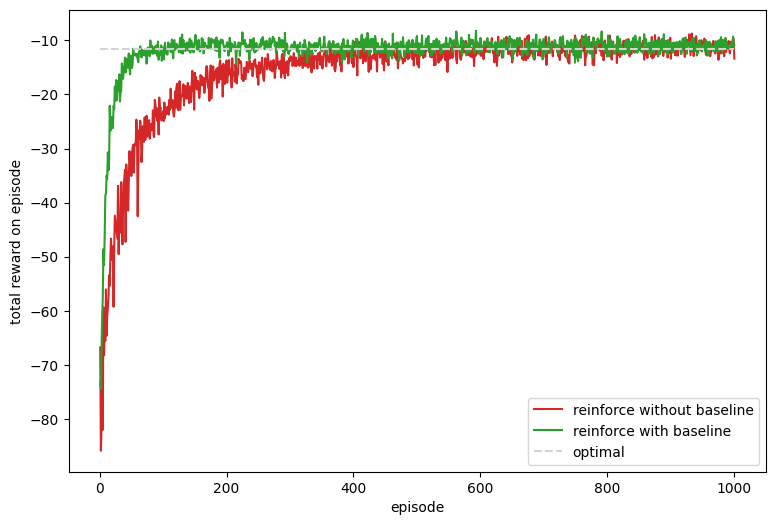

In [62]:
# generate figure
plt.figure(figsize=(9, 6))

plt.plot(np.arange(EPISODES) + 1, reinforce_rewards.mean(axis=0), color='tab:red', label='reinforce without baseline')
plt.plot(np.arange(EPISODES) + 1, baseline_rewards.mean(axis=0), color='tab:green', label='reinforce with baseline')
plt.plot(np.arange(EPISODES) + 1, -11.6 * np.ones(EPISODES), ls='dashed', color='lightgray', label='optimal')

plt.ylabel('total reward on episode')
plt.xlabel('episode')
plt.legend(loc='lower right')

plt.show()